In [4]:
!pip3 install detecto


In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torchvision import transforms
from detecto import core, utils, visualize

In [2]:
from tqdm.notebook import tqdm

In [3]:
dataset = core.Dataset('/content/drive/My Drive/Anh CMND')
model = core.Model([
    'top_left', 'top_right', 'bottom_left', 'bottom_right'
])

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [5]:
torch.cuda.is_available()

True

In [6]:
losses = model.fit(dataset, epochs=10, verbose=True, learning_rate=0.001)

Epoch 1 of 10


/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Epoch 2 of 10
Epoch 3 of 10
Epoch 4 of 10
Epoch 5 of 10
Epoch 6 of 10
Epoch 7 of 10
Epoch 8 of 10
Epoch 9 of 10
Epoch 10 of 10


In [27]:
model.save('id_card_4_corner.pth')

In [48]:
model.get_internal_model()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [49]:
fname = '/content/drive/My Drive/Anh CMND/cmnd_L_Th_Trai_1.jpg'
image = utils.read_image(fname)

In [50]:
labels, boxes, scores = model.predict(image)

In [51]:
print(labels)

['bottom_left', 'top_right', 'top_left', 'bottom_right']


In [52]:
print(boxes)

tensor([[  0.6109, 253.4874,  20.8656, 271.5294],
        [399.5276,   0.9414, 418.8253,  15.4476],
        [  1.4785,   1.3888,  17.2016,  14.9452],
        [396.9645, 249.8265, 418.9500, 270.6786]])


In [53]:
import cv2

for i, bbox in enumerate(boxes):
    bbox = list(map(int, bbox))
    x_min, y_min, x_max, y_max = bbox
    cv2.rectangle(image,(x_min,y_min),(x_max,y_max),(0,255,0),2)
    cv2.putText(image, labels[i], (x_min, y_min), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0))

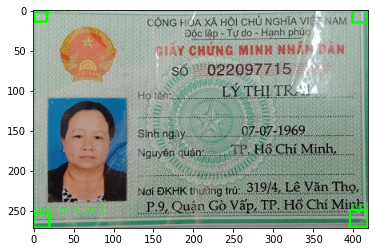

In [54]:
plt.imshow(image)

In [56]:
import numpy as np 

def non_max_suppression_fast(boxes, labels, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    #  
    # initialize the list of picked indexes   
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
         np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
    
    final_labels = [labels[idx] for idx in pick]
    final_boxes = boxes[pick].astype("int")
    
    return final_boxes, final_labels

In [57]:
final_boxes, final_labels = non_max_suppression_fast(boxes.numpy(), labels, 0.15)

In [58]:
final_boxes

array([[  0, 253,  20, 271],
       [396, 249, 418, 270],
       [399,   0, 418,  15],
       [  1,   1,  17,  14]])

In [59]:
final_labels

['bottom_left', 'bottom_right', 'top_right', 'top_left']

In [60]:
def get_center_point(box):
    xmin, ymin, xmax, ymax = box
    return (xmin + xmax) // 2, (ymin + ymax) // 2

In [61]:
final_points = list(map(get_center_point, final_boxes))

In [62]:
label_boxes = dict(zip(final_labels, final_points))
print(label_boxes)

{'bottom_left': (10, 262), 'bottom_right': (407, 259), 'top_right': (408, 7), 'top_left': (9, 7)}


In [63]:
def perspective_transoform(image, source_points):
    dest_points = np.float32([[0,0], [500,0], [500,300], [0,300]])
    M = cv2.getPerspectiveTransform(source_points, dest_points)
    dst = cv2.warpPerspective(image, M, (500, 300))
    
    return dst

In [64]:
source_points = np.float32([
    label_boxes['top_left'], label_boxes['top_right'], label_boxes['bottom_right'], label_boxes['bottom_left']
])

# Transform 
crop = perspective_transoform(image, source_points)

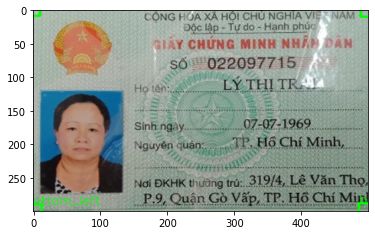

In [65]:
plt.imshow(crop)